In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import curve_fit

In [37]:
#Loading the Data and List Creation/start
a = np.loadtxt('ASTR19_F24_group_project_data.txt', dtype='str')
i=0

datetemp=[]
timetemp=[]
time=[]
height=[]
date=[]

for arr in a: #fix this part
	datetemp.append(int(arr[0]))
	timetemp.append(arr[1])
	height.append(float(arr[2]))

for elem in timetemp:
	splitelem=elem.split(':')
	abstime = (int(splitelem[0])*60+int(splitelem[1]))
	time.append(abstime)


df = pd.DataFrame({
    'DayOfYear': datetemp,
    'Time': timetemp,
    'Height': height,
    'TimeInMinutes': time,
})

# Combine DayOfYear and Time into a single DateTime column
df['DateTime'] = pd.to_datetime(df['DayOfYear'].apply(lambda x: f"2022-{x:03d}") + ' ' + df['Time'], format='%Y-%j %H:%M')

# Check if the DateTime was parsed correctly
print(df.head())

#uncertainity error
heighterr=0.25

   DayOfYear   Time  Height  TimeInMinutes            DateTime
0          1   8:07    6.57            487 2022-01-01 08:07:00
1          1  15:37   -0.39            937 2022-01-01 15:37:00
2          2   8:55    5.38            535 2022-01-02 08:55:00
3          2  16:25   -1.74            985 2022-01-02 16:25:00
4          3   9:45    5.26            585 2022-01-03 09:45:00


In [27]:
def fittedcurve(x,a,b,c,d,e,f,g,h,i):
    return a*np.sin((b)*np.sin((c)*x+d)+i) + e*np.sin((f)*x+h)+g 

date=np.array(date)
height=np.array(height)

params,cov = curve_fit(fittedcurve,date,height,maxfev=2170000000,p0=[9.00002,-2,10,10,10,10,10,10,10],method='trf',bounds=(-100,400))
print(params)
fit = fittedcurve(date,*params)

fitstd=np.std(fit)
print(np.linalg.cond(cov))
np.diag(cov)

[54.93630697  0.2536969  -5.84897135 -6.75519616  0.22693351 10.18029646
 56.22092745  8.44031909 10.92361374]
1775670286834.6094


array([4.44780525e+07, 2.41062022e+02, 2.33111537e-04, 1.33941312e-01,
       1.30483365e-01, 1.72243471e-02, 4.44823859e+07, 1.01523330e+01,
       1.94760983e+01])

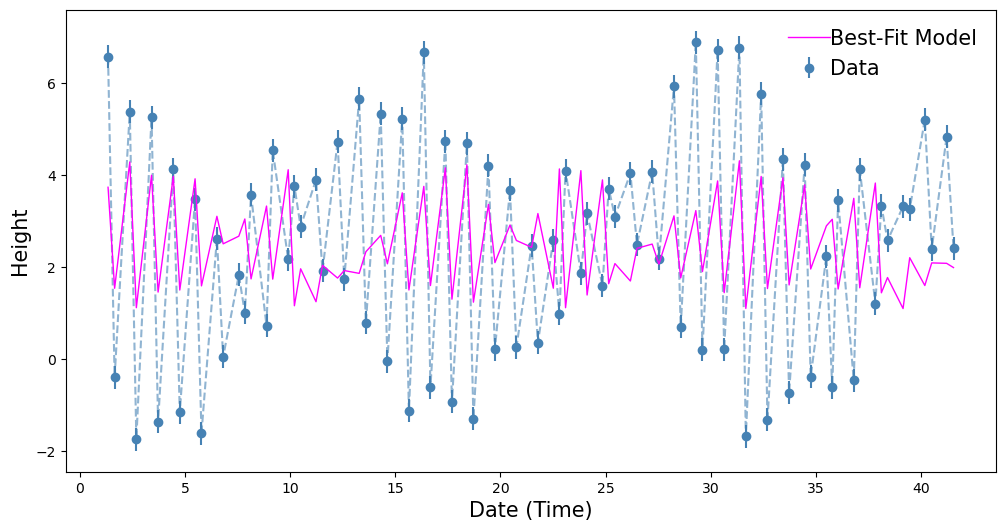

In [28]:
fig = plt.figure(figsize=(12,6),linewidth=1)

fit = fittedcurve(date,*params) #*params unpacks the params[] list generated by curve_fit()


plt.errorbar(date,height,yerr=heighterr,color='steelblue',alpha=1,fmt='o',label='Data')
plt.plot(date,fit,color='magenta',zorder=3,linewidth=1, label='Best-Fit Model')
plt.plot(date,height,color='steelblue',linestyle='dashed',alpha=0.6)
plt.xlabel('Date (Time)', fontsize =15)
plt.ylabel('Height', fontsize =15)
plt.legend(frameon=False,fontsize=15, handletextpad=0)

plt.savefig("ASTR19_Group Project", bbox_inches="tight",facecolor="white")

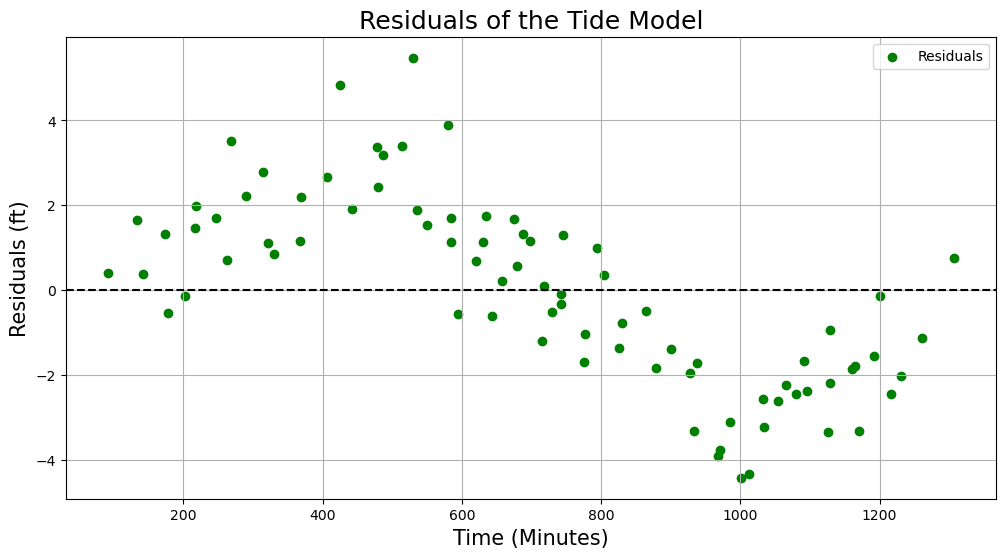

Standard Deviation of Residuals: 2.1833109851465817


In [49]:
residuals = height - fit

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['TimeInMinutes'], residuals, color='green', label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time (Minutes)', fontsize=15)
plt.ylabel('Residuals (ft)', fontsize=15)
plt.title('Residuals of the Tide Model', fontsize=18)
plt.legend()
plt.grid(True)
plt.savefig('Residuals_Plot.pdf', bbox_inches="tight")
plt.show()

residual_std = np.std(residuals)
print(f"Standard Deviation of Residuals: {residual_std}")


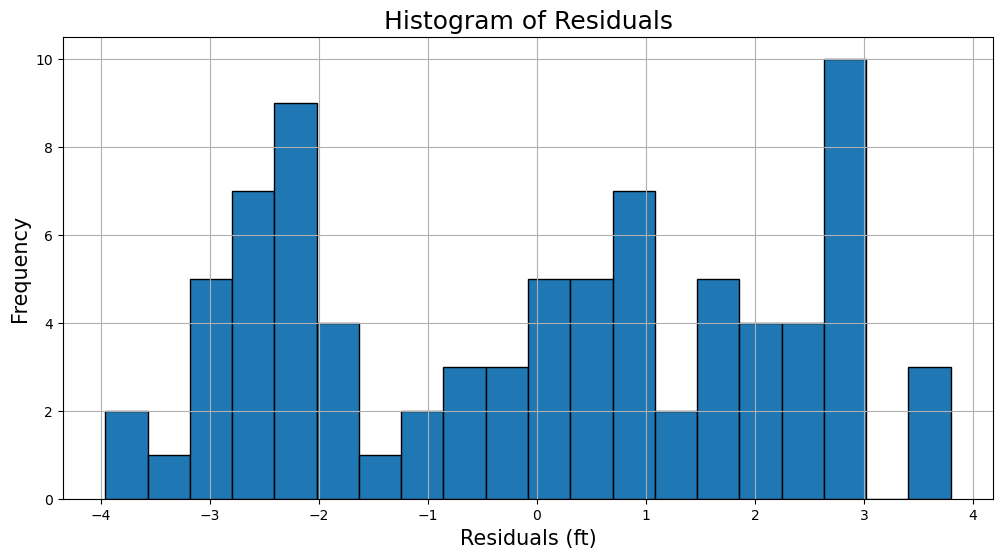

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(residuals, bins=20, edgecolor='black')
ax.set_xlabel('Residuals (ft)', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('Histogram of Residuals', fontsize=18)
plt.grid(True)
plt.savefig('Residuals_Histogram.pdf', bbox_inches="tight")
plt.show()


Fitted parameters: A=-1.3170560565473073, omega=0.5259166167416358, phi=-0.8144659397586397, B=2.454944552641078


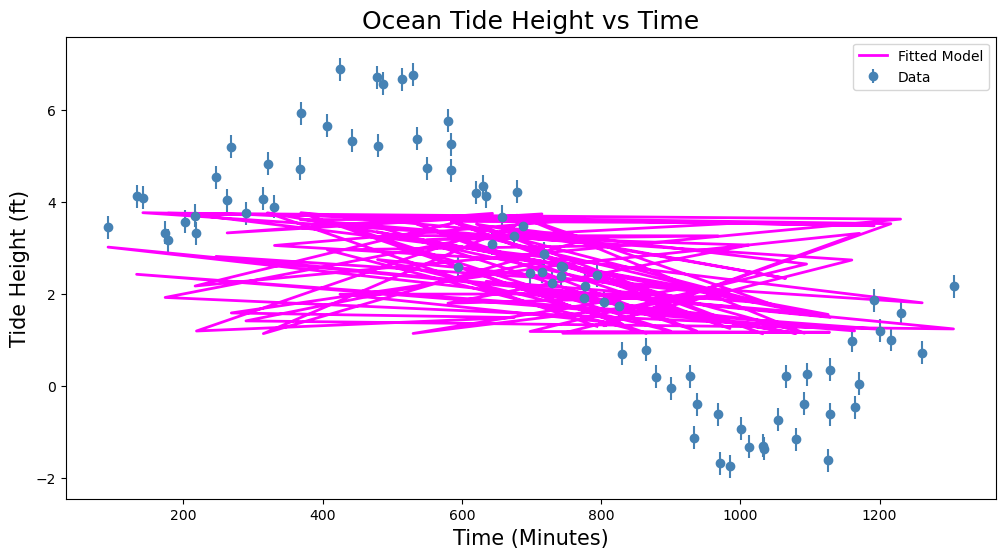

In [38]:
# Define the oscillatory model
def fittedcurve(x, A, omega, phi, B):
    return A * np.sin(omega * x + phi) + B

# Define initial guesses for the parameters (you can adjust these if needed)
initial_guess = [2.5, 2 * np.pi / 12, 0, 3]  # A, omega, phi, B

# Fit the model to the data
params, covariance = curve_fit(fittedcurve, df['TimeInMinutes'], df['Height'], p0=initial_guess, maxfev=5000)

# Extract the fitted parameters
A, omega, phi, B = params
print(f"Fitted parameters: A={A}, omega={omega}, phi={phi}, B={B}")

# Generate the fitted curve using the optimal parameters
fit = fittedcurve(df['TimeInMinutes'], *params)

# Plot the data and the fitted model
plt.figure(figsize=(12, 6))
plt.errorbar(df['TimeInMinutes'], df['Height'], yerr=heighterr, fmt='o', label='Data', color='steelblue')
plt.plot(df['TimeInMinutes'], fit, label='Fitted Model', color='magenta', linewidth=2)
plt.xlabel('Time (Minutes)', fontsize=15)
plt.ylabel('Tide Height (ft)', fontsize=15)
plt.title('Ocean Tide Height vs Time', fontsize=18)
plt.legend()
plt.show()


In [42]:
# Filter the DataFrame for January 14th and inspect the DateTime column
january_14_df = df[df['DateTime'].dt.date == pd.to_datetime('2022-01-14').date()]

# Print the filtered DataFrame to see the DateTime and Height for January 14
print(january_14_df[['DateTime', 'Height']])

# Define the tsunami time you are looking for
tsunami_time = pd.to_datetime('2022-01-14 12:00:00')

# Find the index of the row with the closest DateTime to the tsunami time
closest_time_index = (df['DateTime'] - tsunami_time).abs().idxmin()

# Add 2ft to the Height at the closest time index
df.at[closest_time_index, 'Height'] += 2  # Add 2ft to this height

# Print the updated row to verify
print(df.loc[closest_time_index])


              DateTime  Height
26 2022-01-14 07:22:00    5.33
27 2022-01-14 15:00:00   -0.04
DayOfYear                         14
Time                           15:00
Height                          1.96
TimeInMinutes                    900
DateTime         2022-01-14 15:00:00
Name: 27, dtype: object


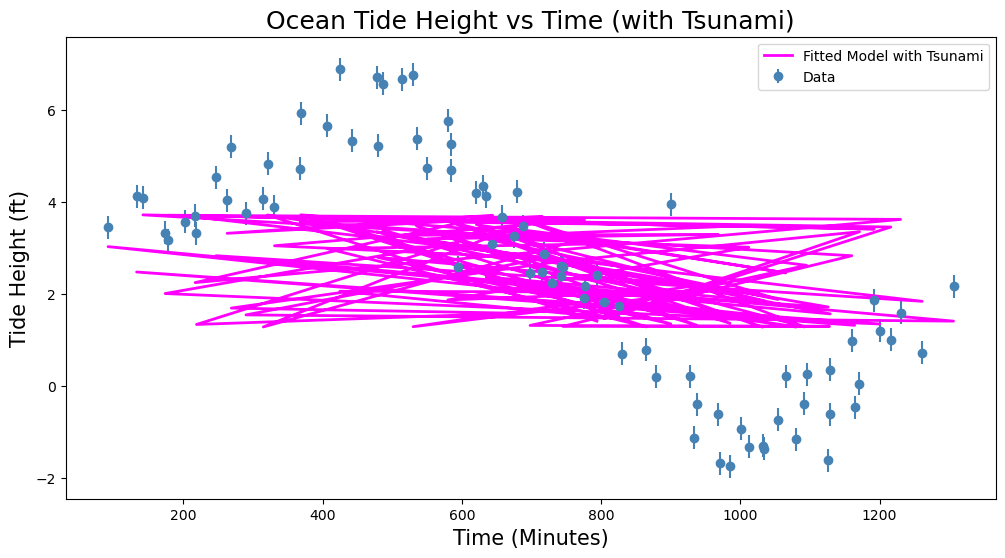

Tsunami deviation in standard deviations: 0.9101750437489892


In [45]:
# Add the tsunami impact (2ft increase) at the specific high tide index
tsunami_time_index = df[(df['DateTime'] == '2022-01-14 15:00:00')].index[0]  # Corrected to 15:00:00
df.at[tsunami_time_index, 'Height'] += 2  # Add 2ft to this height

# Refit the model with the updated data (including the tsunami outlier)
params, covariance = curve_fit(fittedcurve, df['TimeInMinutes'], df['Height'], p0=initial_guess, maxfev=5000)

# Generate the fitted curve using the optimal parameters
fit = fittedcurve(df['TimeInMinutes'], *params)

# Plot the updated fit with the tsunami outlier
plt.figure(figsize=(12, 6))
plt.errorbar(df['TimeInMinutes'], df['Height'], yerr=heighterr, fmt='o', label='Data', color='steelblue')
plt.plot(df['TimeInMinutes'], fit, label='Fitted Model with Tsunami', color='magenta', linewidth=2)
plt.xlabel('Time (Minutes)', fontsize=15)
plt.ylabel('Tide Height (ft)', fontsize=15)
plt.title('Ocean Tide Height vs Time (with Tsunami)', fontsize=18)
plt.legend()
plt.show()

# Calculate the deviation of the tsunami event in terms of standard deviations
# Compute residuals to get the standard deviation
residuals = df['Height'] - fit
residual_std = np.std(residuals)

tsunami_deviation = 2 / residual_std  # The 2ft tsunami deviation
print(f"Tsunami deviation in standard deviations: {tsunami_deviation}")
